# Model Analysis
This notebook trains a machine learning model to predict LaLiga match outcomes. The model classifies each match as:
- **1**: Home team wins
- **3**: Away team wins
- **2**: Draw

## Step 1: Data Preprocessing

In [1]:
# import libraries ncessary for preprocessing
import pandas as pd
import numpy as np
import sqlite3

from sklearn.model_selection import train_test_split

In [2]:
# create a connection with the given database
con = sqlite3.connect("../laliga.sqlite")

# read the matches table from the database into Pandas DataFrames
df_matches = pd.read_sql_query("SELECT * from Matches", con)

# close the connection of the database
con.close()

In [3]:
def count_points(last_5):
    if last_5 == 0:
        return 0
        
    count = 0
    for i in last_5:
        if i == 'W':
            count += 3
        elif i == 'T':
            count += 1
    return count

def extend_data(input_data):
    # clean the inputted dataframe
    # make a copy of the data so the original dataframe does not change
    data = input_data.copy()
    
    # drop the "time" column because it contains to many "None" values, and the "date" column because it is not used
    data.drop(columns = ['time', 'date'], inplace = True)
    
    # drop NaN values (there are only NaN values left in the "score" column)
    data.dropna(inplace = True)
    
    # create two new columns, one for the score of the home team, and one for the score of the away team, drop the score column
    data[['home_score', 'away_score']] = data['score'].str.split(':', expand=True).astype(int)
    data.drop(columns=['score'], inplace = True)
    
    # create a new column to show which team won (1 for home team, 2 for away team and 'X' for a draw)
    data['winner'] = data.apply(lambda row: 1 if row['home_score'] > row['away_score'] else 2 if row['home_score'] < row['away_score'] else 'X', axis=1)


    # use the code from exercise 10 to gather more data for the matches
    # make a copy of the data dataframe so the original dataframe does not change
    data_copy = data

    # calculate, for every unique group of season, division, matchday and home_team, how many goals the team made (GF) and got against (GA)
    # and if the team won (W=1), lost (L=1) or tied (T=1)
    home_stats = data_copy.groupby(['season', 'division', 'matchday', 'home_team']).agg(
        GF=('home_score', 'sum'), GA=('away_score', 'sum'),
        W=('winner', lambda x: (x == 1).sum()),
        L=('winner', lambda x: (x == 2).sum()),
        T=('winner', lambda x: (x == 'X').sum())
    ).reset_index().rename(columns={'home_team': 'team', 'result': 'home_result'})

    # calculate, for every unique group of season, division, matchday and away_team, how many goals the team made (GF) and got against (GA)
    # and if the team won (W=1), lost (L=1) or tied (T=1)
    away_stats = data_copy.groupby(['season', 'division', 'matchday', 'away_team']).agg(
        GF=('away_score', 'sum'), GA=('home_score', 'sum'),
        W=('winner', lambda x: (x == 2).sum()),
        L=('winner', lambda x: (x == 1).sum()),
        T=('winner', lambda x: (x == 'X').sum())
    ).reset_index().rename(columns={'away_team': 'team', 'result': 'away_result'})

    # add the statestics for the home teams and the away teams together
    combined_stats = pd.concat([home_stats, away_stats]).fillna(0)
    # calculate the goal difference for each row, a negative goal difference means the team got more goals against then that it made
    combined_stats['GD'] = combined_stats['GF'] - combined_stats['GA']
    # calculate the amount of points for each row, a win is worth 3 points, and a tie 1
    combined_stats['Pts'] = combined_stats['W'] * 3 + combined_stats['T']
    # create a result column that contains "W" if the team one the match, 'L' if the team lost the match and "T" if the team tied the match
    combined_stats['result'] = combined_stats.apply(lambda row: 'W' if row['W'] > 0 else ('L' if row['L'] > 0 else 'T'), axis=1)

    # sort the combined statistics so they are in the right order
    results = combined_stats.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD', 'GF'])
    # cumulative sum 'GF', 'GA', 'GD', 'W', 'L', 'T' and 'Pts', so that it is updated for every matchday
    results[['GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']] = results.groupby(['season', 'division', 'team'])[['GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']].cumsum()

    # sort the dataframe again so that the rank can be calculated
    results = results.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD', 'GF'], ascending=[True, True, True, False, False, False])    
    # calculate the rank
    results['rank'] = results.groupby(['season', 'division', 'matchday']).cumcount() + 1
    # sort the dataframe so everything is in the right order
    results = results.sort_values(by=['season', 'division', 'matchday', 'rank'], ascending=[False, True, True, True]).reset_index(drop=True)

    # create a column with the last 5 results of the team in the same season and division
    results['last_5'] = results.apply(lambda row: results[
        (results['season'] == row['season']) &
        (results['division'] == row['division']) &
        (results['matchday'] <= row['matchday']) &
        (results['matchday'] >= max(1, row['matchday'] - 4)) &
        (results['team'] == row['team'])
    ]['result'].tolist()[-5:], axis=1)

    # count the amount of points the last 5 results would total to
    results['last_5'] = results['last_5'].apply(lambda x: count_points(x))  
    
    # the final result dataframe
    results = results[['season', 'division', 'matchday', 'rank', 'team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'result', 'last_5']]
      
    # shift the results dataframe so that it can be combined with the data dataframe later
    # make a copy of the results dataframe so the original dataframe does not change
    results_shifted = results.copy()
    # shift the matchday up by 1 so that the results dataframe will merge good with the data dataframe
    results_shifted['matchday'] += 1
    
    # rename the columns so that that values are clear, the values are from just before the matchday where they are shown started
    results_shifted = results_shifted.rename(columns={
        'rank': 'prev_rank',
        'GF': 'prev_GF', 'GA': 'prev_GA', 'GD': 'prev_GD',
        'W': 'prev_W', 'L': 'prev_L', 'T': 'prev_T', 'Pts': 'prev_Pts',
        'result': 'prev_result', 'last_5': 'prev_last_5'
    })
    
    # merge the data dataframe with the shifted results dataframe, first only for the home teams
    data = data.merge(results_shifted, 
                      how='left', 
                      left_on=['season', 'division', 'matchday', 'home_team'], 
                      right_on=['season', 'division', 'matchday', 'team']).fillna(0)
    
    # drop the team column that was created
    data.drop(columns=['team'], inplace=True)
    
    # merge the data dataframe again with the shifted results dataframe, now for the away teams, and ensure the prefixes are correct
    data = data.merge(results_shifted, 
                      how='left', 
                      left_on=['season', 'division', 'matchday', 'away_team'], 
                      right_on=['season', 'division', 'matchday', 'team'], 
                      suffixes=('_home', '_away')).fillna(0)
    
    # drop the team column that was created
    data.drop(columns=['team'], inplace=True)

    # space to add extra data to the data dataframe or change existing data
    data['winner'] = data.apply(lambda row: 1 if row['winner'] == 1 else 2 if row['winner'] == 2 else 0, axis=1)






    # Create a helper column to represent team pairs in an unordered manner
    data['team_pair'] = data.apply(lambda row: frozenset([row['home_team'], row['away_team']]), axis=1)
    
    # Group by 'team_pair' instead of separate home and away teams to include all matches between the two teams
    data['head_to_head_last_5'] = data.groupby('team_pair')['winner'].transform(
        lambda x: x.rolling(5, 1).apply(lambda y: sum(y == 1) / 5, raw=True)
    )

    # 1. Head-to-Head Draw Ratio in the last 5 matches
    data['head_to_head_draw_ratio'] = data.groupby('team_pair')['winner'].transform(
        lambda x: x.rolling(5, 1).apply(lambda y: sum(y == 'X') / 5, raw=True)
    )
    
    # 2. Head-to-Head Average Goals Scored by Home Team in the last 5 matches
    data['head_to_head_avg_goals_home'] = data.groupby('team_pair')['home_score'].transform(
        lambda x: x.rolling(5, 1).mean()
    )
    
    # 3. Head-to-Head Average Goals Scored by Away Team in the last 5 matches
    data['head_to_head_avg_goals_away'] = data.groupby('team_pair')['away_score'].transform(
        lambda x: x.rolling(5, 1).mean()
    )
    
    # 4. Head-to-Head Goal Difference (Home Goals - Away Goals) in the last 5 matches
    data['head_to_head_goal_diff'] = data.groupby('team_pair').apply(
        lambda x: (x['home_score'] - x['away_score']).rolling(5, 1).mean()
    ).reset_index(level=0, drop=True)
    
    # Drop the helper column to clean up the dataframe
    data.drop(columns=['team_pair'], inplace=True)






    return data

# Additional imports if necessary
from collections import Counter

def extend_data_with_h2h(input_data):
    # Call the original function to get the extended data first
    data = extend_data(input_data)

    # Step 1: Add Head-to-Head Statistics
    data['team_pair'] = data.apply(lambda row: frozenset([row['home_team'], row['away_team']]), axis=1)

    # Filter relevant columns for head-to-head calculations
    h2h_data = data[['season', 'division', 'matchday', 'home_team', 'away_team', 'home_score', 'away_score', 'winner', 'team_pair']]

    # Step 2: Initialize new columns for H2H statistics
    data['h2h_last_5_wins_home'] = 0
    data['h2h_last_5_wins_away'] = 0
    data['h2h_last_5_draws'] = 0
    data['h2h_last_5_goals_home'] = 0
    data['h2h_last_5_goals_away'] = 0

    # Define a function to retrieve the last 5 head-to-head games (excluding the current match)
    def get_h2h_stats(row, h2h_data):
        team_pair = row['team_pair']
        matchday = row['matchday']
        season = row['season']

        # Get the last 5 matches between the two teams *before* the current match
        h2h_matches = h2h_data[
            (h2h_data['team_pair'] == team_pair) &
            ((h2h_data['season'] < season) | 
             ((h2h_data['season'] == season) & (h2h_data['matchday'] < matchday)))
        ].sort_values(by=['season', 'matchday'], ascending=[False, False]).head(5)

        # Count the results of these last 5 matches
        home_wins = sum(h2h_matches['winner'] == 1)
        away_wins = sum(h2h_matches['winner'] == 2)
        draws = sum(h2h_matches['winner'] == 'X')
        
        # Calculate the goals scored in these head-to-head matches
        goals_home = h2h_matches['home_score'].sum()
        goals_away = h2h_matches['away_score'].sum()

        return home_wins, away_wins, draws, goals_home, goals_away

    # Apply the function to each row to populate new columns
    h2h_stats = data.apply(lambda row: get_h2h_stats(row, h2h_data), axis=1)
    data[['h2h_last_5_wins_home', 'h2h_last_5_wins_away', 'h2h_last_5_draws', 'h2h_last_5_goals_home', 'h2h_last_5_goals_away']] = pd.DataFrame(h2h_stats.tolist(), index=data.index)

    # Drop the helper column used for unique team pairs
    data.drop(columns=['team_pair'], inplace=True)

    # Return the final extended dataframe with additional H2H statistics
    return data

In [4]:
# select the right seasons for the training and testing data
training_data = df_matches[df_matches['season'].isin(['2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020'])]
testing_data_1 = df_matches[df_matches['season'].isin(['2017-2018', '2018-2019', '2019-2020','2020-2021'])]
testing_data_2 = df_matches[df_matches['season'].isin(['1928-1929', '1929-1930', '1930-1931','1931-1932'])]
testing_data_3 = df_matches[df_matches['season'].isin(['1954-1955', '1955-1956', '1956-1957','1957-1958'])]

In [5]:
# extend the training data
training_data = extend_data_with_h2h(training_data)
training_data

/tmp/ipykernel_83548/3397098513.py:155: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['head_to_head_goal_diff'] = data.groupby('team_pair').apply(


,season,division,matchday,home_team,away_team,home_score,away_score,winner,prev_rank_home,prev_GF_home,...,head_to_head_last_5,head_to_head_draw_ratio,head_to_head_avg_goals_home,head_to_head_avg_goals_away,head_to_head_goal_diff,h2h_last_5_wins_home,h2h_last_5_wins_away,h2h_last_5_draws,h2h_last_5_goals_home,h2h_last_5_goals_away
0,2007-2008,1,1,Real Madrid,Atlético Madrid,2,1,1,0.0,0.0,...,0.2,0.0,2.0,1.00,1.00,0,0,0,0,0
1,2007-2008,1,1,Sevilla FC,Getafe,4,1,1,0.0,0.0,...,0.2,0.0,4.0,1.00,3.00,0,0,0,0,0
2,2007-2008,1,1,Athletic,CA Osasuna,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0,0,0,0,0
3,2007-2008,1,1,Dep. La Coruña,UD Almería,0,3,2,0.0,0.0,...,0.0,0.0,0.0,3.00,-3.00,0,0,0,0,0
4,2007-2008,1,1,RCD Mallorca,Levante,3,0,1,0.0,0.0,...,0.2,0.0,3.0,0.00,3.00,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10941,2019-2020,2,42,CD Numancia,CD Tenerife,2,1,1,20.0,43.0,...,0.8,0.0,2.0,0.80,1.20,3,0,0,9,4
10942,2019-2020,2,42,Racing,Rayo Vallecano,1,2,2,22.0,38.0,...,0.4,0.0,2.0,1.25,0.75,2,0,0,7,3
10943,2019-2020,2,42,Sporting Gijón,SD Huesca,0,1,2,11.0,40.0,...,0.4,0.0,0.8,1.00,-0.20,3,1,0,5,4
10944,2019-2020,2,42,Real Zaragoza,Ponferradina,2,1,1,5.0,57.0,...,0.4,0.0,1.4,0.80,0.60,2,0,0,9,4


In [6]:
training_data[((training_data['home_team'] == 'Dep. La Coruña') & (training_data['away_team'] == 'CF Fuenlabrada')) | ((training_data['home_team'] == 'CF Fuenlabrada') & (training_data['away_team'] == 'Dep. La Coruña'))]

,season,division,matchday,home_team,away_team,home_score,away_score,winner,prev_rank_home,prev_GF_home,...,head_to_head_last_5,head_to_head_draw_ratio,head_to_head_avg_goals_home,head_to_head_avg_goals_away,head_to_head_goal_diff,h2h_last_5_wins_home,h2h_last_5_wins_away,h2h_last_5_draws,h2h_last_5_goals_home,h2h_last_5_goals_away
10631,2019-2020,2,14,CF Fuenlabrada,Dep. La Coruña,1,1,0,3.0,18.0,...,0.0,0.0,1.0,1.0,0.0,0,0,0,0,0
10945,2019-2020,2,42,Dep. La Coruña,CF Fuenlabrada,2,1,1,19.0,41.0,...,0.2,0.0,1.5,1.0,0.5,0,0,0,1,1


In [7]:
training_data[((training_data['home_team'] == 'Barcelona') & (training_data['away_team'] == 'Real Madrid')) | ((training_data['home_team'] == 'Real Madrid') & (training_data['away_team'] == 'Barcelona'))]

,season,division,matchday,home_team,away_team,home_score,away_score,winner,prev_rank_home,prev_GF_home,...,head_to_head_last_5,head_to_head_draw_ratio,head_to_head_avg_goals_home,head_to_head_avg_goals_away,head_to_head_goal_diff,h2h_last_5_wins_home,h2h_last_5_wins_away,h2h_last_5_draws,h2h_last_5_goals_home,h2h_last_5_goals_away
168,2007-2008,1,17,Barcelona,Real Madrid,0,1,2,2.0,32.0,...,0.0,0.0,0.0,1.000000,-1.000000,0,0,0,0,0
358,2007-2008,1,36,Real Madrid,Barcelona,4,1,1,1.0,73.0,...,0.2,0.0,2.0,1.000000,1.000000,0,1,0,0,1
521,2008-2009,1,15,Barcelona,Real Madrid,2,0,1,1.0,44.0,...,0.4,0.0,2.0,0.666667,1.333333,1,1,0,4,2
710,2008-2009,1,34,Real Madrid,Barcelona,2,6,2,2.0,77.0,...,0.4,0.0,2.0,2.000000,0.000000,2,1,0,6,2
878,2009-2010,1,12,Barcelona,Real Madrid,1,0,1,2.0,29.0,...,0.6,0.0,1.8,1.600000,0.200000,2,2,0,8,8
1064,2009-2010,1,31,Real Madrid,Barcelona,0,2,2,1.0,83.0,...,0.6,0.0,1.8,1.800000,0.000000,3,2,0,9,8
1269,2010-2011,1,13,Barcelona,Real Madrid,5,0,1,2.0,33.0,...,0.6,0.0,2.0,1.600000,0.400000,3,2,0,9,9
1453,2010-2011,1,32,Real Madrid,Barcelona,1,1,0,2.0,72.0,...,0.4,0.0,1.8,1.800000,0.000000,3,2,0,10,8
1672,2011-2012,1,16,Real Madrid,Barcelona,1,3,2,1.0,53.0,...,0.4,0.0,1.6,1.200000,0.400000,2,2,0,9,9
1862,2011-2012,1,35,Barcelona,Real Madrid,1,2,2,2.0,100.0,...,0.2,0.0,1.6,1.600000,0.000000,2,2,0,8,6


In [9]:
# extend the testing data
testing_data_1 = extend_data_with_h2h(testing_data_1)
testing_data_1
testing_data_2 = extend_data_with_h2h(testing_data_2)
testing_data_2
testing_data_3 = extend_data_with_h2h(testing_data_3)
testing_data_3

/tmp/ipykernel_83548/3397098513.py:155: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['head_to_head_goal_diff'] = data.groupby('team_pair').apply(
/tmp/ipykernel_83548/3397098513.py:155: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['head_to_head_goal_diff'] = data.groupby('team_pair').apply(
/tmp/ipykernel_83548/3397098513.py:155: DeprecationWarning: DataFrameGroupBy.apply operated on the groupin

,season,division,matchday,home_team,away_team,home_score,away_score,winner,prev_rank_home,prev_GF_home,...,head_to_head_last_5,head_to_head_draw_ratio,head_to_head_avg_goals_home,head_to_head_avg_goals_away,head_to_head_goal_diff,h2h_last_5_wins_home,h2h_last_5_wins_away,h2h_last_5_draws,h2h_last_5_goals_home,h2h_last_5_goals_away
0,1954-1955,1,1,Real Madrid,Valencia,1,2,2,0.0,0.0,...,0.0,0.0,1.00,2.00,-1.00,0,0,0,0,0
1,1954-1955,1,1,UD Las Palmas,Atlético Madrid,4,1,1,0.0,0.0,...,0.2,0.0,4.00,1.00,3.00,0,0,0,0,0
2,1954-1955,1,1,Barcelona,Sevilla FC,4,2,1,0.0,0.0,...,0.2,0.0,4.00,2.00,2.00,0,0,0,0,0
3,1954-1955,1,1,Real Valladolid,Real Sociedad,1,0,1,0.0,0.0,...,0.2,0.0,1.00,0.00,1.00,0,0,0,0,0
4,1954-1955,1,1,CD Málaga,Celta de Vigo,0,0,0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,1957-1958,2,34,Girona,Racing,1,0,1,10.0,41.0,...,0.4,0.0,1.25,0.75,0.50,1,1,0,4,3
1882,1957-1958,2,34,Indauchu,Tarrasa,3,1,1,4.0,61.0,...,0.6,0.0,2.80,1.00,1.80,3,0,0,15,6
1883,1957-1958,2,34,Rayo Vallecano,Real Oviedo,0,2,2,7.0,44.0,...,0.6,0.0,2.25,1.00,1.25,3,0,0,9,2
1884,1957-1958,2,34,CE Sabadell,CyD Leonesa,3,0,1,1.0,58.0,...,0.4,0.0,2.50,1.25,1.25,1,2,0,7,5


In [10]:
def remove_first_three_seasons(data):
    # Identify the first three unique seasons in the dataset
    first_three_seasons = data['season'].sort_values().unique()[:3]
    
    # Filter out rows that belong to these first three seasons
    filtered_data = data[~data['season'].isin(first_three_seasons)]
    
    return filtered_data

# remove the first 3 years of both datasets
training_data = remove_first_three_seasons(training_data)
testing_data_1 = remove_first_three_seasons(testing_data_1)
testing_data_2 = remove_first_three_seasons(testing_data_2)
testing_data_3 = remove_first_three_seasons(testing_data_3)

In [11]:
training_data['winner'].value_counts()

winner
1    3927
0    2268
2    2225
Name: count, dtype: int64

In [12]:
from sklearn.utils import resample

# Separate each class into different DataFrames
class_1 = training_data[training_data['winner'] == 1]
class_0 = training_data[training_data['winner'] == 0]
class_2 = training_data[training_data['winner'] == 2]

# Find the size of the majority class
majority_size = class_1.shape[0]

# Oversample the minority classes to match the majority class size
class_0_oversampled = resample(class_0, replace=True, n_samples=majority_size, random_state=42)
class_2_oversampled = resample(class_2, replace=True, n_samples=majority_size, random_state=42)

# Concatenate the oversampled minority classes with the majority class
balanced_training_data = pd.concat([class_1, class_0_oversampled, class_2_oversampled])

# Shuffle the balanced data
balanced_training_data = balanced_training_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
balanced_training_data['winner'].value_counts()


winner
2    3927
0    3927
1    3927
Name: count, dtype: int64

In [13]:
balanced_training_data

,season,division,matchday,home_team,away_team,home_score,away_score,winner,prev_rank_home,prev_GF_home,...,head_to_head_last_5,head_to_head_draw_ratio,head_to_head_avg_goals_home,head_to_head_avg_goals_away,head_to_head_goal_diff,h2h_last_5_wins_home,h2h_last_5_wins_away,h2h_last_5_draws,h2h_last_5_goals_home,h2h_last_5_goals_away
0,2012-2013,1,14,Sevilla FC,Real Valladolid,1,2,2,10.0,18.0,...,0.6,0.0,2.200000,1.400000,0.8,4,0,0,12,5
1,2017-2018,1,37,Real Betis,Sevilla FC,2,2,0,5.0,56.0,...,0.4,0.0,1.800000,1.800000,0.0,2,2,0,7,7
2,2019-2020,2,34,Albacete,SD Huesca,2,2,0,17.0,25.0,...,0.2,0.0,1.000000,0.800000,0.2,1,1,0,4,3
3,2012-2013,1,7,Real Zaragoza,Getafe,0,1,2,15.0,5.0,...,0.2,0.0,0.800000,1.200000,-0.4,1,2,0,4,7
4,2014-2015,2,35,CA Osasuna,Albacete,2,1,1,20.0,30.0,...,0.4,0.0,2.000000,0.500000,1.5,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11776,2012-2013,1,14,Dep. La Coruña,Real Betis,2,3,2,17.0,19.0,...,0.2,0.0,0.800000,1.600000,-0.8,1,2,0,2,5
11777,2019-2020,2,15,UD Las Palmas,Alcorcón,1,1,0,13.0,15.0,...,0.4,0.0,1.400000,0.400000,1.0,3,0,0,8,1
11778,2011-2012,2,20,Real Valladolid,Alcorcón,1,1,0,4.0,29.0,...,0.4,0.0,1.333333,0.333333,1.0,2,0,0,3,0
11779,2014-2015,1,24,Atlético Madrid,UD Almería,3,0,1,3.0,47.0,...,0.6,0.0,2.200000,1.000000,1.2,2,1,0,9,6


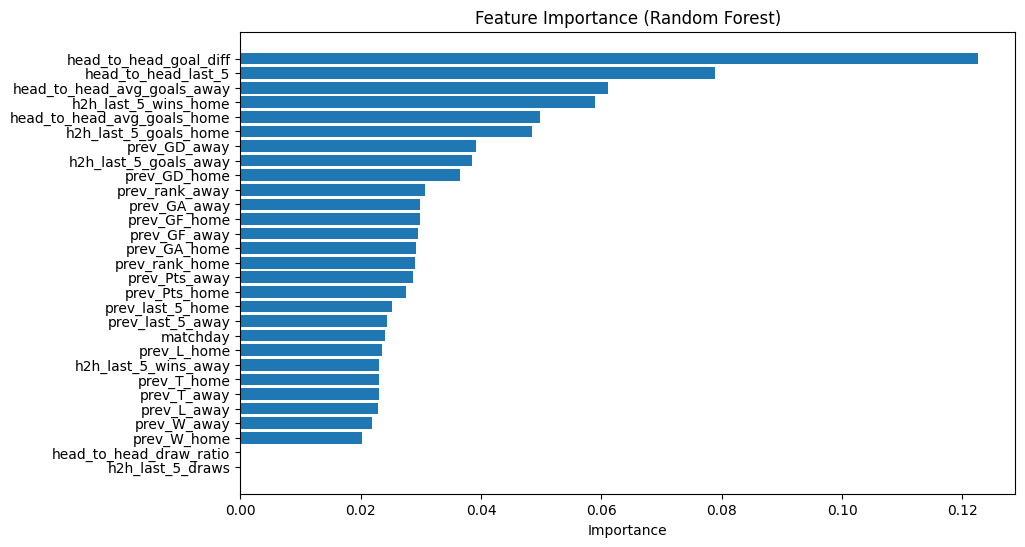

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
import matplotlib.pyplot as plt
import pandas as pd

# Assuming balanced_training_data is ready and 'winner' is the target
X = balanced_training_data.drop(columns=['winner', 'home_team', 'away_team', 'division', 'season', 'home_score', 'away_score']).select_dtypes(include=[np.number])
y = balanced_training_data["winner"]

# Method 1: Feature Importance using Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importances from the Random Forest model
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

# # Method 2: Recursive Feature Elimination (RFE)
# from sklearn.linear_model import LogisticRegression

# rfe_model = LogisticRegression(max_iter=1000, random_state=42)
# rfe = RFE(estimator=rfe_model, n_features_to_select=15)
# rfe.fit(X, y)

# # Get top features selected by RFE
# rfe_features = X.columns[rfe.support_]
# print("\nTop features selected by RFE:", rfe_features)

# # Method 3: SelectKBest with Chi-Square
# # SelectKBest works best with positive features, so ensure non-negative data
# X_non_negative = X.apply(lambda x: x + abs(x.min()) if x.min() < 0 else x)

# k_best = SelectKBest(score_func=chi2, k=15)
# k_best.fit(X_non_negative, y)

# # Get top features selected by SelectKBest
# k_best_features = X.columns[k_best.get_support()]
# print("\nTop features selected by SelectKBest:", k_best_features)



Training Logistic Regression...

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

     Tie (0)       0.34      0.33      0.34       106
Home Win (1)       0.74      0.81      0.77       339
Away Win (2)       0.64      0.44      0.52       101

    accuracy                           0.65       546
   macro avg       0.57      0.53      0.54       546
weighted avg       0.64      0.65      0.64       546



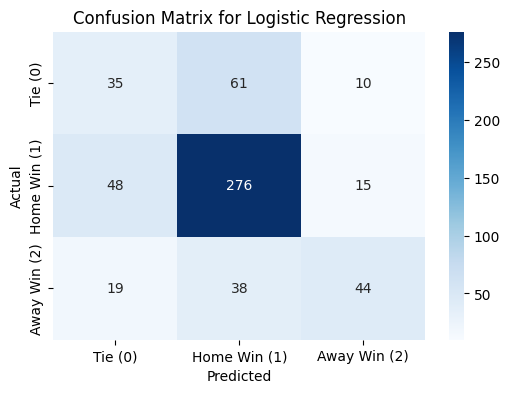


Training Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

     Tie (0)       0.46      0.42      0.44       106
Home Win (1)       0.77      0.84      0.81       339
Away Win (2)       0.59      0.48      0.53       101

    accuracy                           0.69       546
   macro avg       0.61      0.58      0.59       546
weighted avg       0.68      0.69      0.68       546



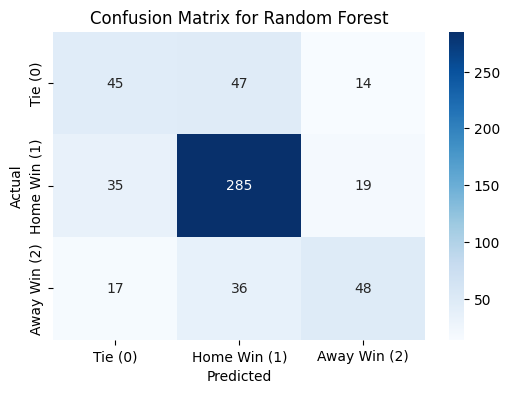


Training Support Vector Machine...

Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

     Tie (0)       0.36      0.30      0.33       106
Home Win (1)       0.73      0.83      0.78       339
Away Win (2)       0.64      0.44      0.52       101

    accuracy                           0.66       546
   macro avg       0.57      0.52      0.54       546
weighted avg       0.64      0.66      0.64       546



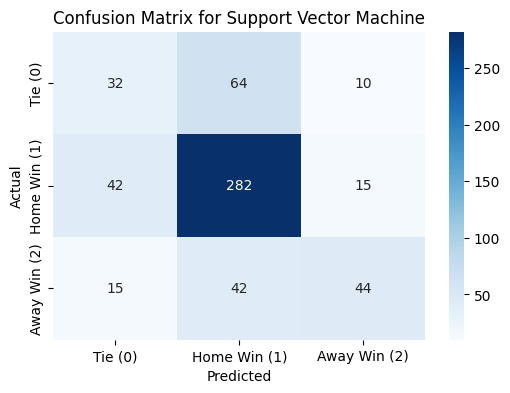


Training Naive Bayes Gaussian...

Classification Report for Naive Bayes Gaussian:
              precision    recall  f1-score   support

     Tie (0)       0.31      0.39      0.34       106
Home Win (1)       0.75      0.79      0.77       339
Away Win (2)       0.68      0.38      0.48       101

    accuracy                           0.63       546
   macro avg       0.58      0.52      0.53       546
weighted avg       0.65      0.63      0.63       546



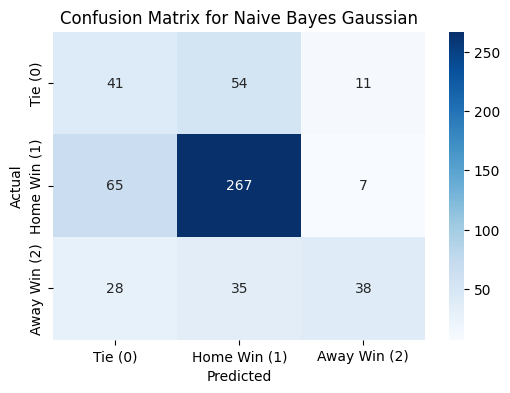

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# standard features
# features = ['prev_rank_home', 'prev_rank_away', 'prev_last_5_home', 'prev_last_5_away', 'GDD', 'prev_T_home', 'prev_T_away'] 
# features = ['GDD', 'prev_GD_home', 'prev_GD_away', 'prev_GF_home', 'prev_GF_away', 'prev_GA_home', 
#             'prev_GA_away', 'prev_rank_home', 'prev_rank_away', 'prev_last_5_home', 'prev_last_5_away',
#             'prev_T_home', 'prev_T_away']
# features = ['GDD', 'prev_rank_home', 'prev_rank_away', 'prev_last_5_home', 'prev_last_5_away', 
#             'prev_L_home', 'prev_L_away', ]\
features = ['head_to_head_goal_diff', 'head_to_head_last_5']

# Assume balanced_training_data and testing_data are already defined
X_train = X[features]
y_train = y
X_test = testing_data_3[features]
y_test = testing_data_3["winner"]

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel="linear"),
    "Naive Bayes Gaussian": GaussianNB()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=["Tie (0)", "Home Win (1)", "Away Win (2)"]))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Tie (0)", "Home Win (1)", "Away Win (2)"],
                yticklabels=["Tie (0)", "Home Win (1)", "Away Win (2)"])
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
